In [ ]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [ ]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error voxels
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [63]:
rand_6g_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 6))

In [64]:
rand_6g_bval_indice_100206

array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239])

In [65]:
bvals_100206_6g = bvals_all_100206[rand_6g_bval_indice_100206]*1e-3

In [66]:
normalized_scan_100206_6g = normalized_scan_100206_full[:, rand_6g_bval_indice_100206]

In [67]:
big_b_indice_100206_6g = np.where(bvals_100206_6g != 0.005)[0]

In [68]:
big_b_indice_100206_6g

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
       91, 92, 93, 94, 95])

In [69]:
bvals_100206_6g_no_b5 = bvals_100206_6g[big_b_indice_100206_6g]

In [70]:
normalized_scan_100206_6g_no_b5 = normalized_scan_100206_6g[:, big_b_indice_100206_6g]

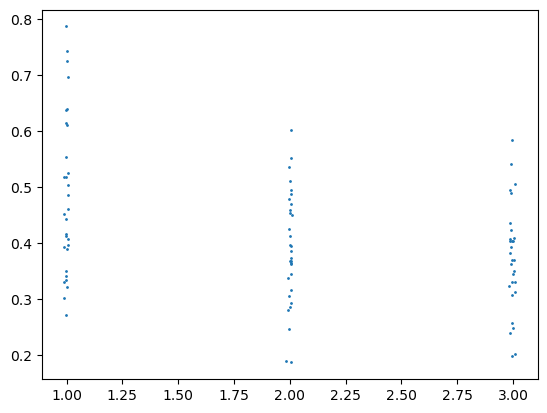

In [71]:
plt.plot(bvals_100206_6g_no_b5, normalized_scan_100206_6g_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [72]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_6g = n_100206_all[:, rand_6g_bval_indice_100206]

In [73]:
print(n_100206_6g.shape)
print(big_b_indice_100206_6g)

(3, 96)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 66 67 68 69 70 71 72 73 74 75 76
 77 78 79 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


In [74]:
n_100206_6g_no_b5 = n_100206_6g[:,big_b_indice_100206_6g].T
print(n_100206_6g_no_b5.shape)

b_values_100206_6g_no_b5 = torch.FloatTensor(bvals_100206_6g_no_b5)
gradient_directions_100206_6g_no_b5 = torch.FloatTensor(n_100206_6g_no_b5)

net = BallStickNet(gradient_directions_100206_6g_no_b5, b_values_100206_6g_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(90, 3)


In [75]:
batch_size = 128
num_batches = len(normalized_scan_100206_6g_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_6g_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [78]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.74it/s]


Loss: 395.2887755979318
Average Loss: 0.05408987077147397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.97it/s]


Loss: 395.2284665692132
Average Loss: 0.054081618304490035
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.61it/s]


Loss: 395.2088250119705
Average Loss: 0.054078930625611726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.48it/s]


Loss: 395.22631144709885
Average Loss: 0.05408132340545961
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.73it/s]


Loss: 395.34725185553543
Average Loss: 0.05409787244875964
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.83it/s]


Loss: 395.186693564523
Average Loss: 0.054075902239261495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.07it/s]


Loss: 395.1580629874952
Average Loss: 0.05407198453578205
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.64it/s]


Loss: 395.208195528714
Average Loss: 0.05407884448942447
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.15it/s]


Loss: 395.1499518896453
Average Loss: 0.05407087464280861
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.43it/s]


Loss: 395.27638710080646
Average Loss: 0.054088175574823
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|██▊                                                                                                                                                           | 131/7308 [00:02<00:56, 127.28it/s]

X_batch: 
torch.Size([128, 90])
tensor([[0.3973, 0.6512, 0.3890,  ..., 0.7004, 0.0968, 0.1039],
        [0.6497, 0.4462, 0.2314,  ..., 0.5276, 0.3392, 0.2310],
        [0.5212, 0.2682, 0.2023,  ..., 0.3064, 0.2946, 0.3086],
        ...,
        [0.1065, 0.0533, 0.0569,  ..., 0.0969, 0.0571, 0.0525],
        [0.4881, 0.2872, 0.1463,  ..., 0.4804, 0.2844, 0.1702],
        [0.4407, 0.2318, 0.1664,  ..., 0.3979, 0.2320, 0.1378]])
X_pred: 
torch.Size([128, 90])
tensor([[0.4264, 0.6193, 0.3207,  ..., 0.6788, 0.1292, 0.0487],
        [0.5296, 0.3220, 0.1569,  ..., 0.4675, 0.3186, 0.3344],
        [0.4344, 0.2669, 0.1949,  ..., 0.4249, 0.2688, 0.2234],
        ...,
        [0.1319, 0.0664, 0.0611,  ..., 0.1289, 0.0689, 0.0622],
        [0.5028, 0.2776, 0.1729,  ..., 0.5047, 0.2613, 0.1576],
        [0.4010, 0.1890, 0.1871,  ..., 0.3990, 0.2138, 0.1893]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.56it/s]


Loss: 395.27391747315414
Average Loss: 0.054087837640004674
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.00it/s]


Loss: 395.1494021615945
Average Loss: 0.05407079942003209
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.19it/s]


Loss: 395.0905392926652
Average Loss: 0.05406274484026617
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.65it/s]


Loss: 395.1494216765277
Average Loss: 0.054070802090384194
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.74it/s]


Loss: 395.2309692290146
Average Loss: 0.054081960759306866
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.91it/s]


Loss: 395.06894850428216
Average Loss: 0.05405979043572553
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.47it/s]


Loss: 395.1140599043574
Average Loss: 0.0540659633147725
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.32it/s]


Loss: 395.17145298677497
Average Loss: 0.05407381677432608
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.50it/s]


Loss: 395.0887173549272
Average Loss: 0.054062495532967596
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.77it/s]


Loss: 395.0752040082589
Average Loss: 0.05406064641601791
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.94it/s]


Loss: 395.1491014494095
Average Loss: 0.05407075827167618
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.00it/s]


Loss: 395.0473415032029
Average Loss: 0.05405683381269881
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.72it/s]


Loss: 395.0195106563624
Average Loss: 0.054053025541374165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.13it/s]


Loss: 395.00266066519544
Average Loss: 0.05405071985019095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.40it/s]


Loss: 395.05833982117474
Average Loss: 0.054058338782317285
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.71it/s]


Loss: 395.0806172734592
Average Loss: 0.05406138714743558
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.67it/s]


Loss: 395.02521151606925
Average Loss: 0.05405380562617258
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.35it/s]


Loss: 395.047051606467
Average Loss: 0.054056794144289405
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.23it/s]


Loss: 394.9477385664359
Average Loss: 0.054043204511006554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.16it/s]


Loss: 394.96601929632016
Average Loss: 0.054045705979244685
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.84it/s]


Loss: 394.98332118429244
Average Loss: 0.05404807350633449
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.07it/s]


Loss: 395.09451186610386
Average Loss: 0.05406328843269073
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.71it/s]


Loss: 394.93504885560833
Average Loss: 0.05404146809737388
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.56it/s]


Loss: 395.0490003519226
Average Loss: 0.054057060803492415
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.83it/s]


Loss: 395.05740848067217
Average Loss: 0.054058211341088146
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.71it/s]


Loss: 395.0445413826965
Average Loss: 0.0540564506544467
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.13it/s]


Loss: 395.03347068605945
Average Loss: 0.054054935780796315
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.19it/s]


Loss: 394.9500762305688
Average Loss: 0.054043524388419376
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.58it/s]


Loss: 395.06587205594406
Average Loss: 0.05405936946578326
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.91it/s]


Loss: 394.9859807579778
Average Loss: 0.054048437432673485
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.59it/s]


Loss: 394.96443825610913
Average Loss: 0.05404548963548291
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.32it/s]


Loss: 394.9434240718838
Average Loss: 0.054042614131346985
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.34it/s]

Loss: 395.0104573289864
Average Loss: 0.054051786717157414
Done, best loss: 394.93504885560833
Done


<All keys matched successfully>

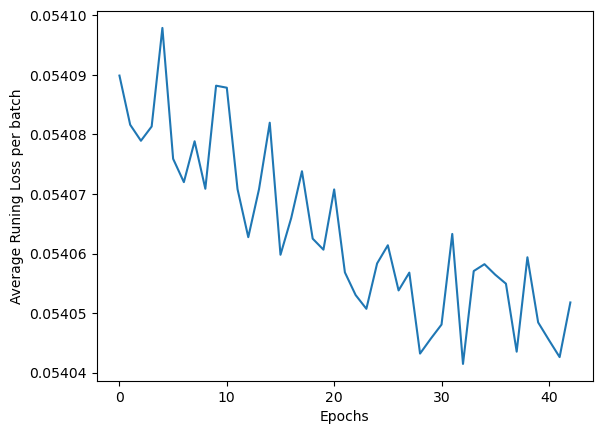

In [79]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [80]:
torch.save(final_model, 'model_100206_6g_01.pt')